# SFVの6種の通常攻撃のSEの主成分分析

音声そのものの共分散を用いて、通常攻撃のどの種類の攻撃がヒットしたかを認識しようとした場合、ほんの少しの時間ずれによっても共分散が大きく変動してしまい、敏感すぎて安定した認識が難しくなることがわかりました。これは、高いサンプリング周波数を使って、1サンプルごとに処理を行わないと認識ができなくなる可能性を示唆しています。こういった処理は、リアルタイム処理には不向きです。

その代わりに、音声の主成分を用いて音声を識別することを考えます。主成分は、元の音声信号群を無相関化したもので、機械学習の前処理などによく用いられています。ざっくり言えば、この処理によって**音声の大体の特徴を抽出することができ、細かいタイミングなどの影響が小さくなる**ことが期待できます。

### 準備
通常攻撃の音声を録音し、ファイルとして用意して`./SFV_SE/`フォルダに格納しておきます。これを読み込んで、正規化し、行列として並べておきます。今回は音声の読み込みに、`soundfile`モジュールを使用しています。

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import soundfile as sf
from sklearn.decomposition import PCA

folder = './SFV_SE/'
filename = ('LP.wav', 'LK.wav', 'MP.wav', 'MK.wav', 'HP.wav', 'HK.wav')

data = [sf.read(folder + k) for k in filename]  # データ, サンプリング周波数を取得
data = [data[k][0] for k in range(6)]  # データのみを取得
data[5] = data[5][0:-1]  # HKのデータが何故か1個多かったので揃える

# 標準偏差が1となるよう正規化
v = [np.std(k) for k in data]
data = [k/j for k,j in zip(data, v)]

# 音声行列生成
A = data[0]
for j in range(1,6):
    A = np.vstack([A,data[j]])

### 主成分の算出

主成分を求めるために`sklearn`を用いています。2次元の図で表して確認するため、まずは第2主成分まで求めてみます。

[23.9, 22.3] 46.2


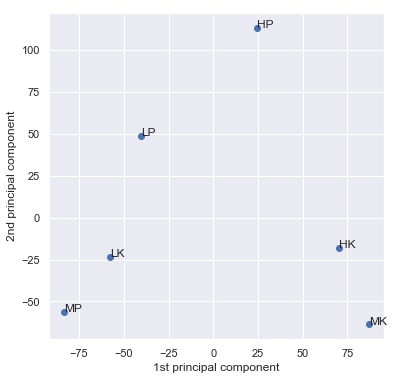

In [2]:
# 主成分分析(PCA)
cr = []  # 寄与率格納用
N_pca = 2
pca = PCA(n_components=N_pca)  # PCAオブジェクト生成
pca.fit(A)  # PCA（共分散行列の生成＞固有値分解）
for k in range(N_pca):
    cr.append(round(pca.explained_variance_ratio_[k]*100, 1))  # 第n主成分の寄与率
tr = pca.fit_transform(A)  # 行列Aをn次元固有空間に射影
print(cr, sum(cr))  # 寄与率, 累積寄与率の表示

# プロット
sb.set()
ax, fig = plt.subplots(figsize=(6,6))
plt.scatter(tr[:,0],tr[:,1])
plt.xlabel('1st principal component')
plt.ylabel('2nd principal component')
label = ['LP', 'LK', 'MP', 'MK', 'HP', 'HK']
for i,k in enumerate(label):
    plt.annotate(k,tr[i])


横軸と縦軸がそれぞれ、第1主成分と第2主成分を表しています。すでに物理量ではなくなっているので単位はありません。
さて、この図ですが、大雑把に言えば**「主成分という尺度で見たときに、お互いがどの程度似ているか」**ということを意味しています。HPはどれとも似ておらず、MPはLKと似ている、といった感じです。一見すると、重ならず程よくばらけているので、例えば新しい音声の成分をここにプロットして、それがどれに近いかを見ることで、音声が識別できそうです。
#### 主成分分析の意味
打撃音声自体は、人間の耳でもかなり識別が難しい、すなわち、元々互いがよく似ていることは、感覚的におわかりかと思います。ここでは打撃1発分の音声データとして20672点分のデータ（サンプリング周波数は44.1kHz）を使っていますが、この大きな音声データが互いにどの程度似ているかを直接比較することは困難です。むしろ、**情報量が多すぎて、その中に似通ったものがたくさん含まれていることが、識別を困難にする**という側面があります。これは「次元の呪い」と呼ばれます。

そこで、識別の前処理として、**別の尺度に置き換えて似通った不要な情報をそぎ落とす**ような処理を加えよう、というのが基本的なアイディアです。主成分分析はそういった処理の一種である、というわけです。
#### 累積寄与率
また、累積寄与率は100%に近いほど、元の音声データの特徴を残していることになります。ここでは第1,2主成分の累積寄与率は46.2%となっているので、このプロットで表される高々2個の主成分では、元のデータの情報が十分に含まれていないことが懸念されます。
#### 第何主成分まで使う？
主成分は寄与率が大きい順に並んでいます。この累積寄与率が90%以上になるように選ぶのが一般的なようです。ただ、4以上を選ぶと、上のプロットは4次元グラフとなってしまい図で表せませんので、直観的な評価が難しくなります。特に、お偉いさんに説明するときは大変な困難が予想されます。

## まとめ
ここでは、主成分分析して音声を識別できそうか、試してみました。プロットから、主成分積を使って音声を識別できる可能性があることがわかりました。次は、実際に録音したゲーム音声で、識別可能性を確認します。